# Pancreatic endocrinogenesis differential geometry


In this tutorial, we will cover following topics:

- learn contionus RNA velocity vector field functions in different spaces (e.g. umap or pca space)
- rank genes based on the jacobian tensor
- build and visualize gene regulatory network with top ranked genes
- gene enrichment analyses of top ranked genes
- visualize Jacobian derived regulatory interactions across cells

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))
# %matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import dynamo as dyn


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Showing package dependecies which may help you debug dependency related bugs

In [2]:
dyn.get_all_dependencies_version()


package dynamo-release pre-commit colorcet cvxopt loompy matplotlib networkx  \
version          1.0.0     2.16.0    2.0.6  1.2.7  3.0.6      3.4.3    2.6.3   

package   numba numdifftools   numpy pandas pynndescent python-igraph  \
version  0.54.1       0.9.40  1.20.3  1.3.4       0.5.5         0.9.8   

package scikit-learn  scipy seaborn setuptools statsmodels    tqdm umap-learn  
version        1.0.2  1.8.0  0.11.2     58.0.4      0.13.2  4.62.3      0.5.2

Loading `pancreatic endocrinogenesis` dataset via `dyn.sample_data`

In [3]:
dyn.configuration.set_figure_params("dynamo", background="white")
adata = dyn.sample_data.pancreatic_endocrinogenesis()


|-----> Downloading data to ./data/endocrinogenesis_day15.h5ad
|-----> [download] in progress: 100.0000%
|-----> [download] finished [5.4869s]


Defining `pancreas_genes` list, which we will investigate in the differential geometry analysis later in this notebook.

In [4]:
pancreas_genes = [
    "Hes1",
    "Nkx6-1",
    "Nkx2-2",
    "Neurog3",
    "Neurod1",
    "Pax4",
    "Pax6",
    "Arx",
    "Pdx1",
    "Ins1",
    "Ins2",
    "Ghrl",
    "Ptf1a",
    "Iapp",
    "Isl1",
    "Sox9",
    "Gcg",
]


## Proprocessing and learn RNA velocities

Normalizing `adata` with monocle recipe, reducing its dimension via PCA and computing velocities in PCA space

In [5]:
dyn.pp.recipe_monocle(adata, n_top_genes=4000, fg_kwargs={"shared_count": 20}, genes_to_append=pancreas_genes)
dyn.tl.dynamics(adata, model="stochastic")
dyn.tl.reduceDimension(adata, n_pca_components=30)
dyn.tl.cell_velocities(adata, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(adata, basis="pca")


|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [17.8821s]


estimating gamma: 100%|██████████| 4000/4000 [02:28<00:00, 27.02it/s]


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0007s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.4131s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.6581s]
|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'grid_velocity_umap', 'grid_velocity_pca'
    obsm: 'X_pca', 'X_umap', 'X', 'cell_cycle_scor

Visualize preprocessing results with a streamline plot on the `umap` basis.

|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


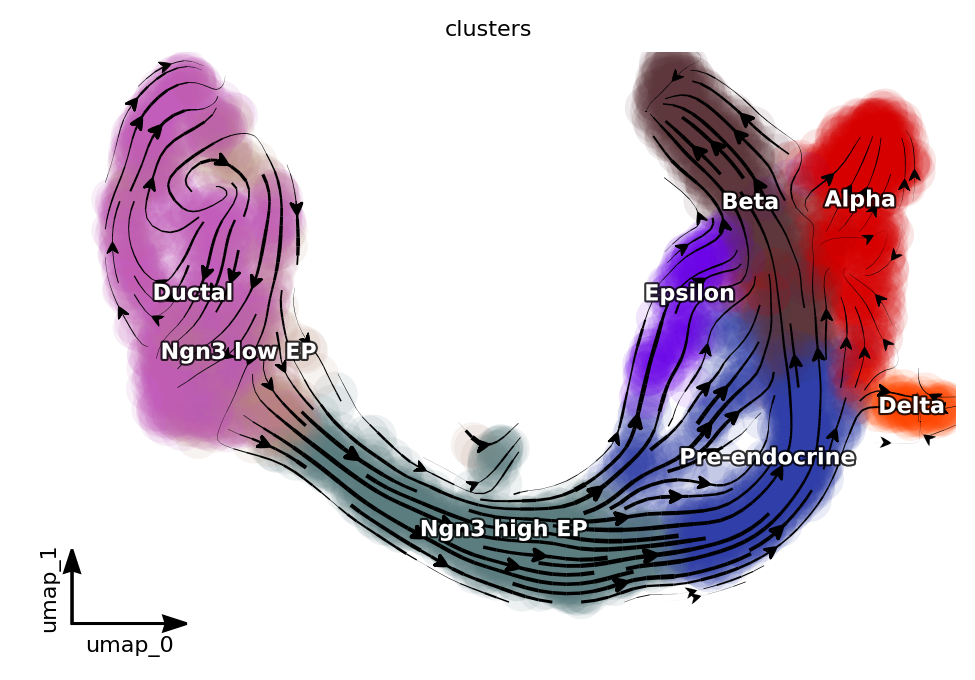

In [6]:
dyn.pl.streamline_plot(adata, color=["clusters"], basis="umap", show_legend="on data", show_arrowed_spines=True)

Visualizing cell velocity vectors via `dyn.pl.cell_wise_vectors`

|-----> X shape: (3696, 2) V shape: (3696, 2)
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


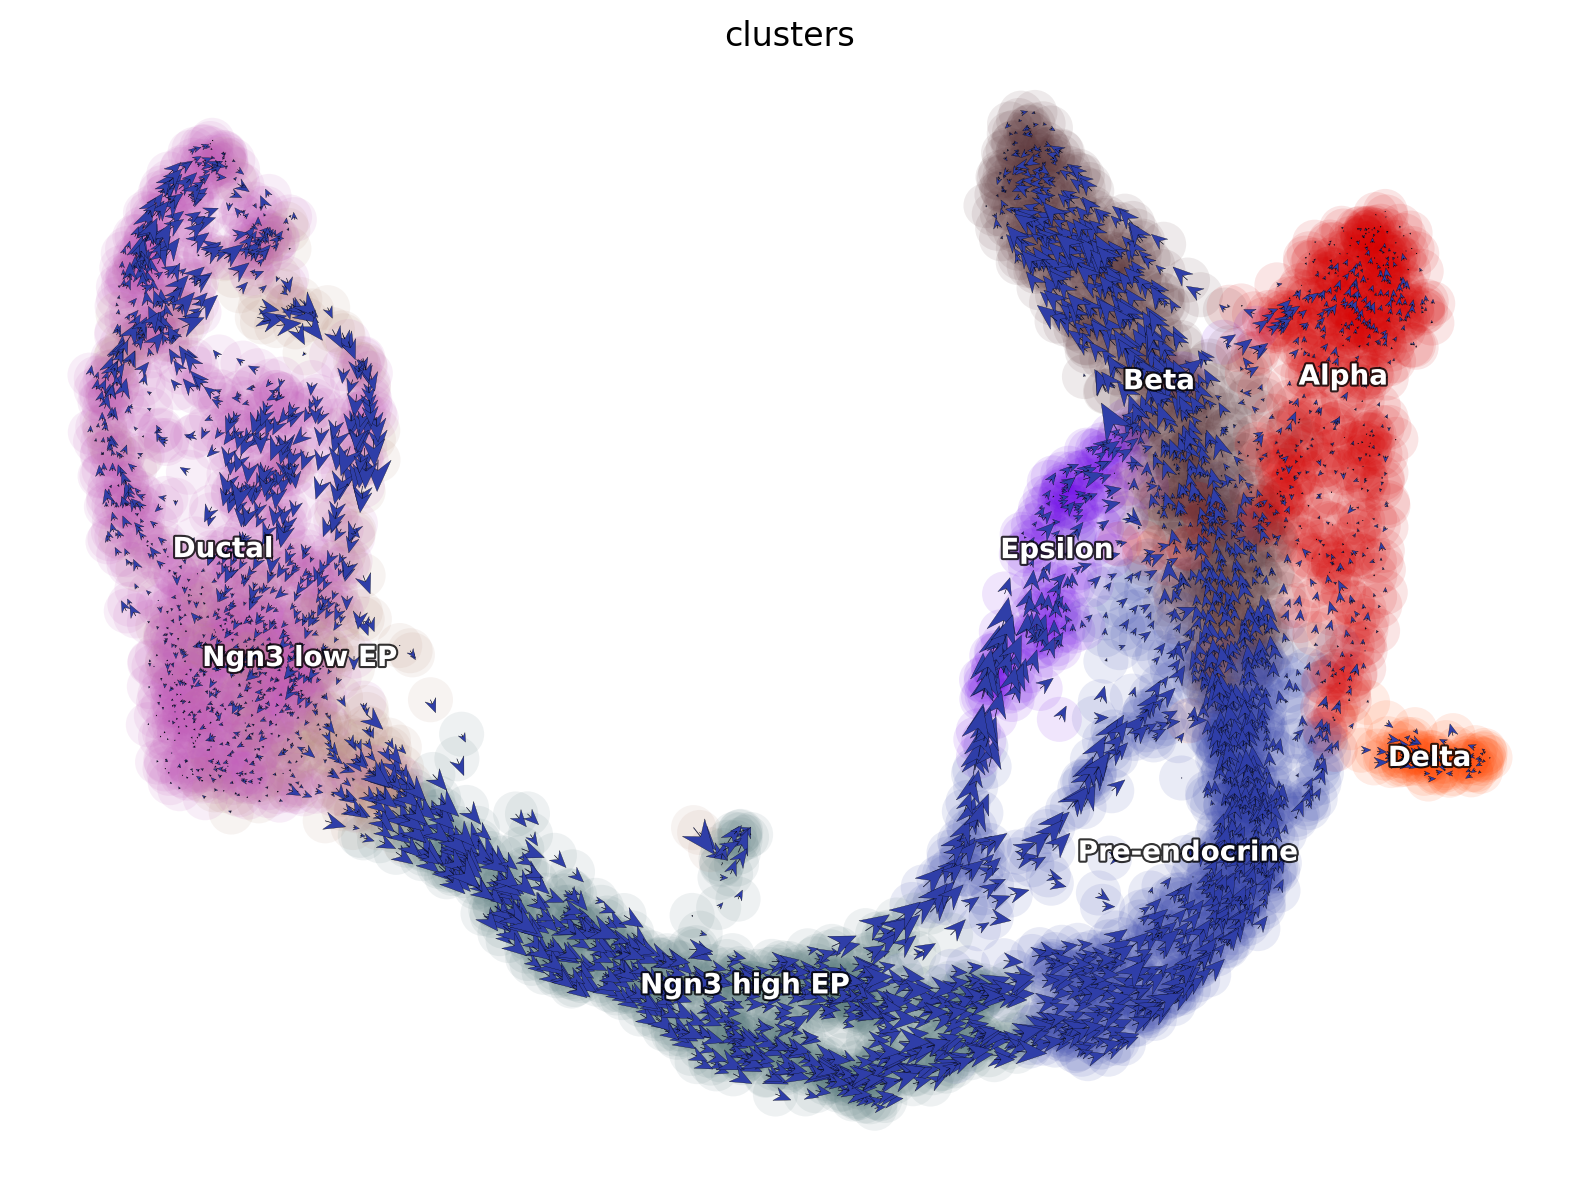

In [7]:
dyn.pl.cell_wise_vectors(
    adata,
    color=["clusters"],
    basis="umap",
    show_legend="on data",
    quiver_length=6,
    quiver_size=6,
    figsize=(8, 6),
    show_arrowed_spines=False,
)


## Differential geometry analyses reveal dynamics and key gene interactions
The diagram below illustrates the differentiation process of pancreatic endocrine cells and key regulatory genes/motifs. 

![Diagram](/gallery/images/diagram.png)

Define the `progenitor` cells: in this pancreatic endocrinogenesis dataset, we treat Doctal cells as progenitor cells.

In [8]:
progenitor = adata.obs_names[adata.obs.clusters.isin(["Ductal"])]
len(progenitor)

916

Next we show how to use `dynamo` to learn a vectorfield. Here we learn the vectorfield on the `pca` basis. The vector field can be learned on the low dimensional embedding and
            can be then projected back to the high dimensional space.   
            Since `curl` is defined in 2d/3d space, we use `umap` vectorfield to compute curl. `umap` and `pca` basis vectorfields will not interfere with each other (prefixed `pca` or `umap`) as you can check computation results in `adata`. You may try other embeddings such as PCA with fewer principe components to compute `curl`.

### Learning dynamics in PCA space via `dyn.vf.VectorField` and compute dynamics

In [9]:
# dyn.tl.cell_velocities(adata, basis="pca")
dyn.vf.VectorField(adata, basis="pca", pot_curl_div=True)
dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)

dyn.vf.speed(adata, basis="pca")
dyn.vf.divergence(adata, basis="pca")
dyn.vf.acceleration(adata, basis="pca")
dyn.vf.curl(adata, basis="umap")


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3509s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from la

Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]

|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.


|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [20.2223s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.9759s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and retur

Calculating 2-D curl: 100%|██████████| 3696/3696 [00:00<00:00, 27838.20it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 33.65it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [22.1098s]



Calculating divergence: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1408s]
|-----> <insert> acceleration to layers in AnnData Object.


Calculating 2-D curl: 100%|██████████| 3696/3696 [00:00<00:00, 28036.52it/s]



The acceleration and divergence accurately highlight hotspots, including a saddle point in ductal cells (negative divergence), exit from this state to early endocrine progenitors (high positive acceleration), the bifurcation point for late progenitors to differentiate into stable cell types (high acceleration and positive divergence), and stable cell types (negative divergence).

|-----> X shape: (3696, 2) V shape: (3696, 2)
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


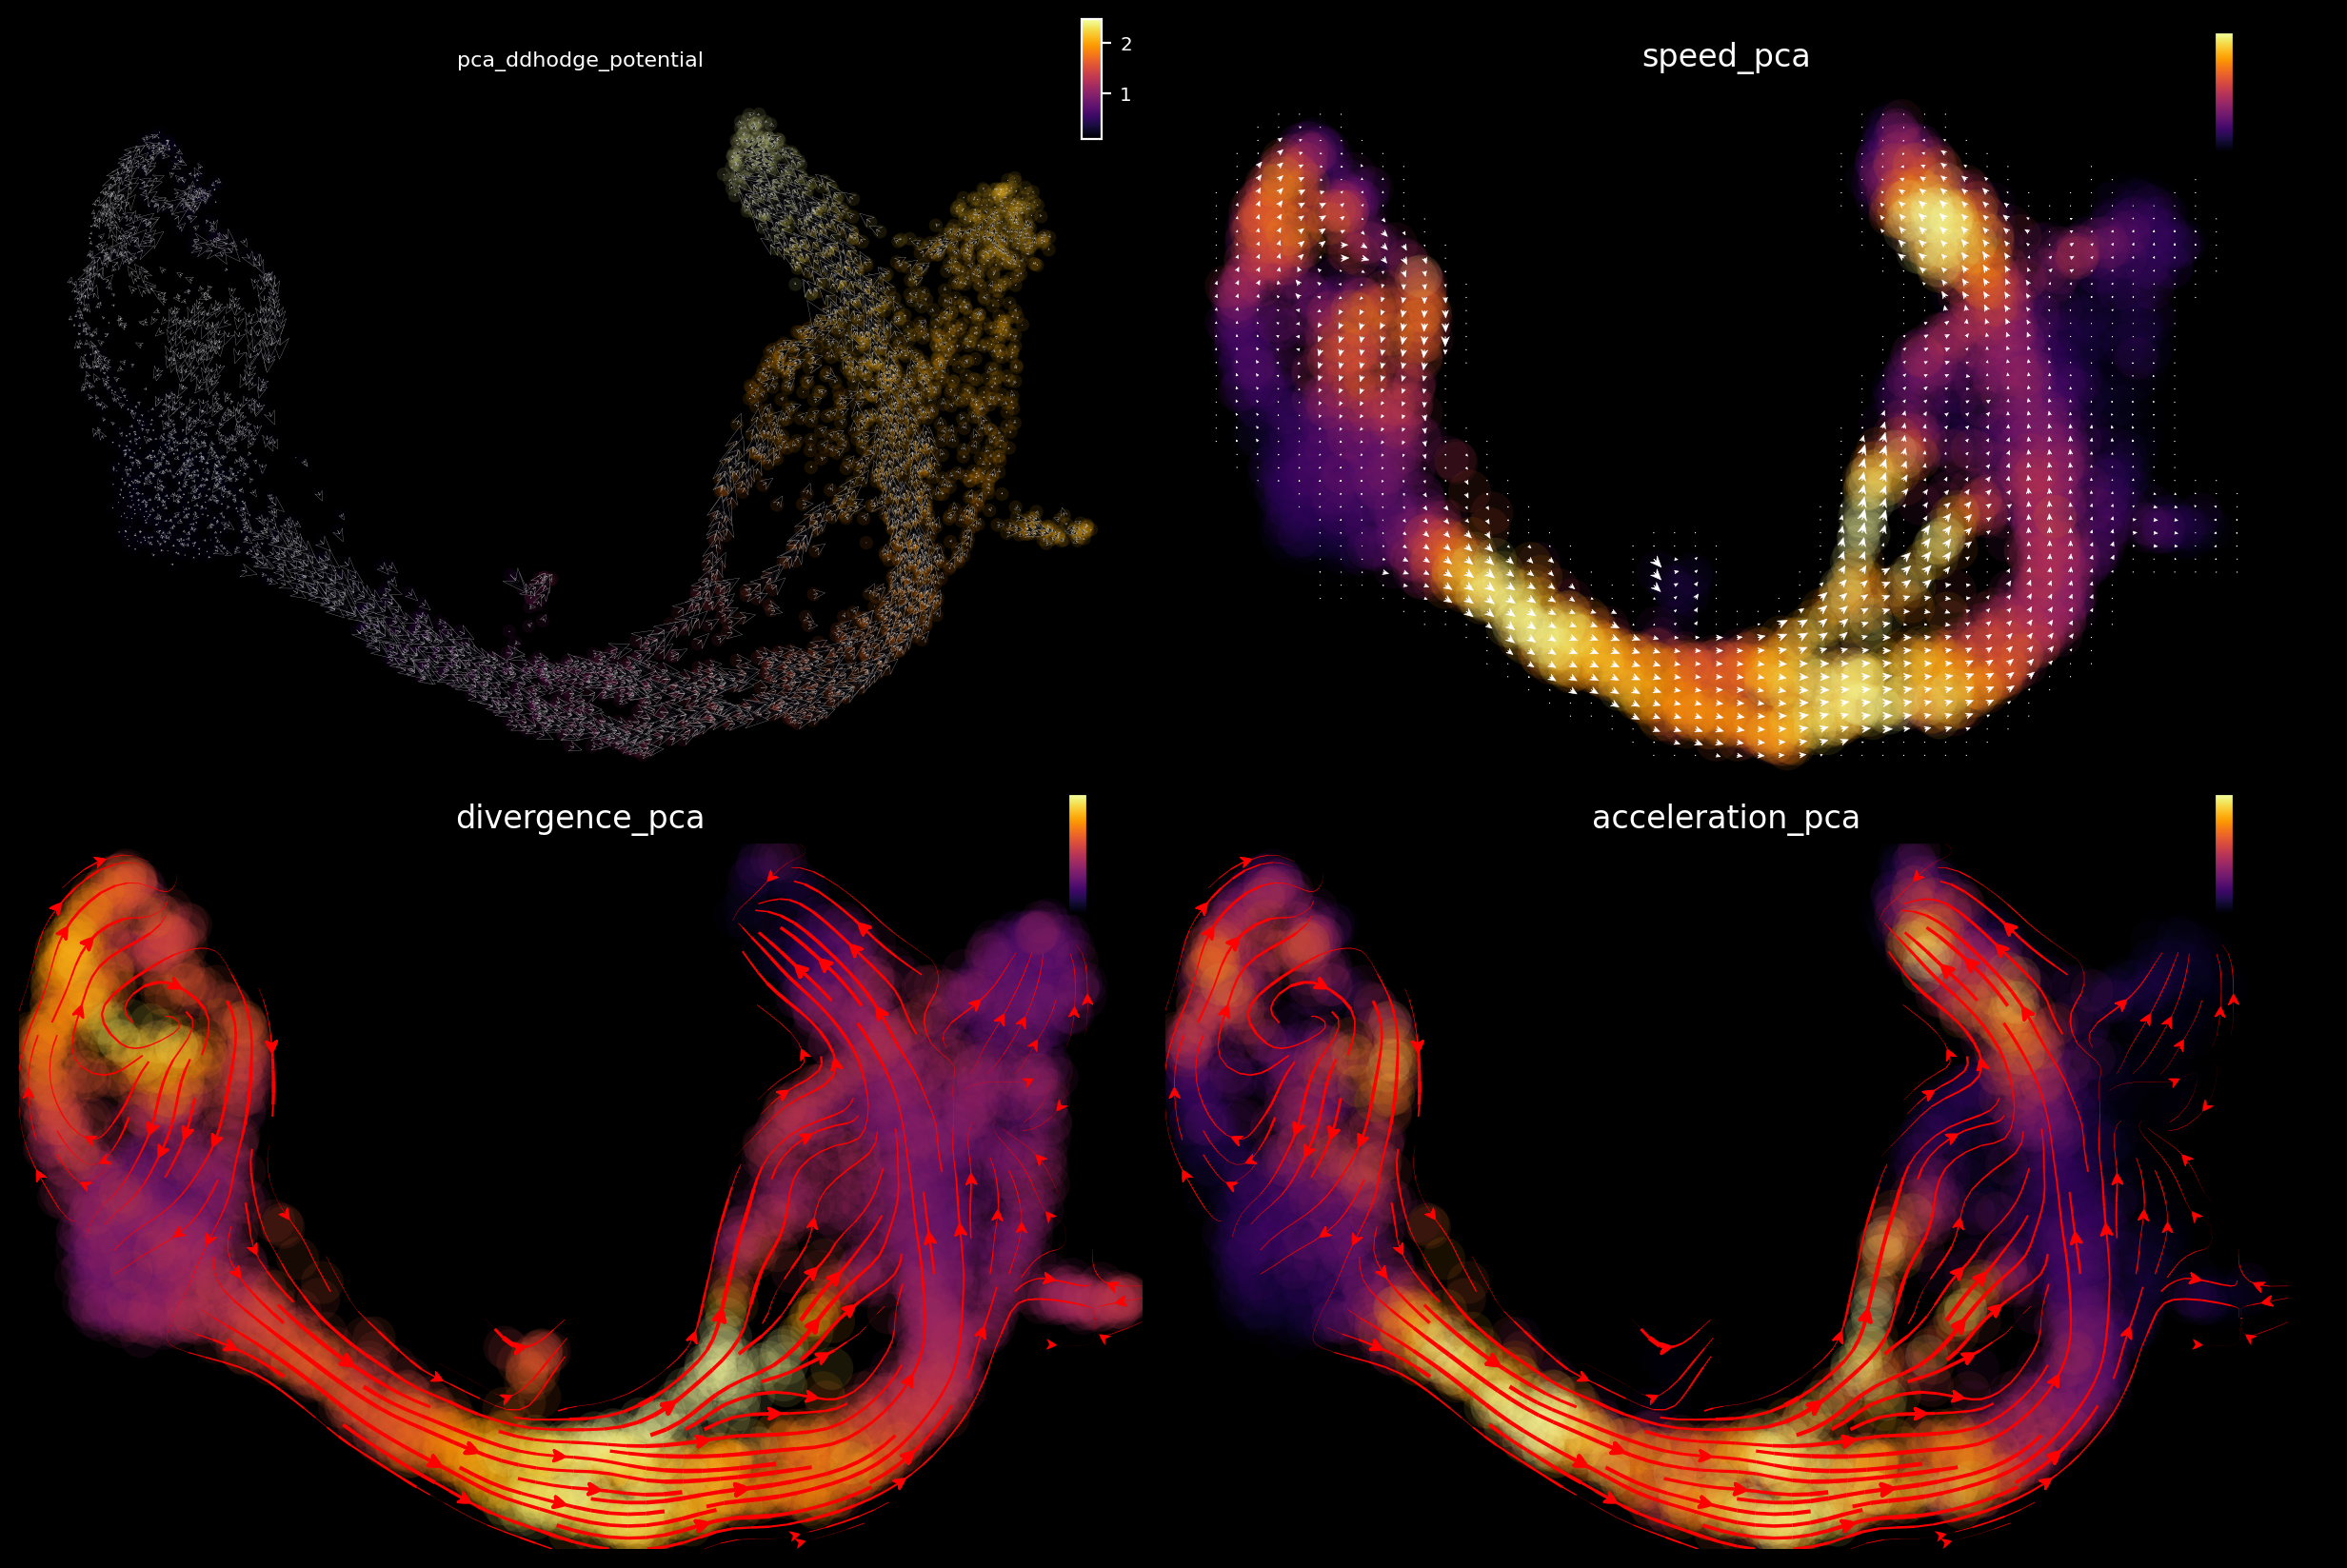

In [10]:
dyn.configuration.set_figure_params("dynamo", background="black")

import matplotlib.pyplot as plt

fig1, fig1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 8))
dyn.pl.cell_wise_vectors(
    adata,
    color="pca_ddhodge_potential",
    pointsize=0.1,
    alpha=0.7,
    ax=fig1_axes[0, 0],
    quiver_length=6,
    quiver_size=6,
    save_show_or_return="return",
    background="black",
)
dyn.pl.grid_vectors(
    adata,
    color="speed_pca",
    basis="umap",
    ax=fig1_axes[0, 1],
    quiver_length=12,
    quiver_size=12,
    save_show_or_return="return",
    background="black",
)
dyn.pl.streamline_plot(
    adata, color="divergence_pca", basis="umap", ax=fig1_axes[1, 0], save_show_or_return="return", background="black"
)
dyn.pl.streamline_plot(
    adata, color="acceleration_pca", basis="umap", ax=fig1_axes[1, 1], save_show_or_return="return", background="black"
)
plt.show()


### Visualizing vectorfield attractors and saddle points via `dyn.pl.topography`

The following 2D UMAP vector field topology shows stable fixed points (attractors) in alpha, beta, and ductal cells, and a saddle point #6 at the branching point between ductal cells and early progenitors.

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


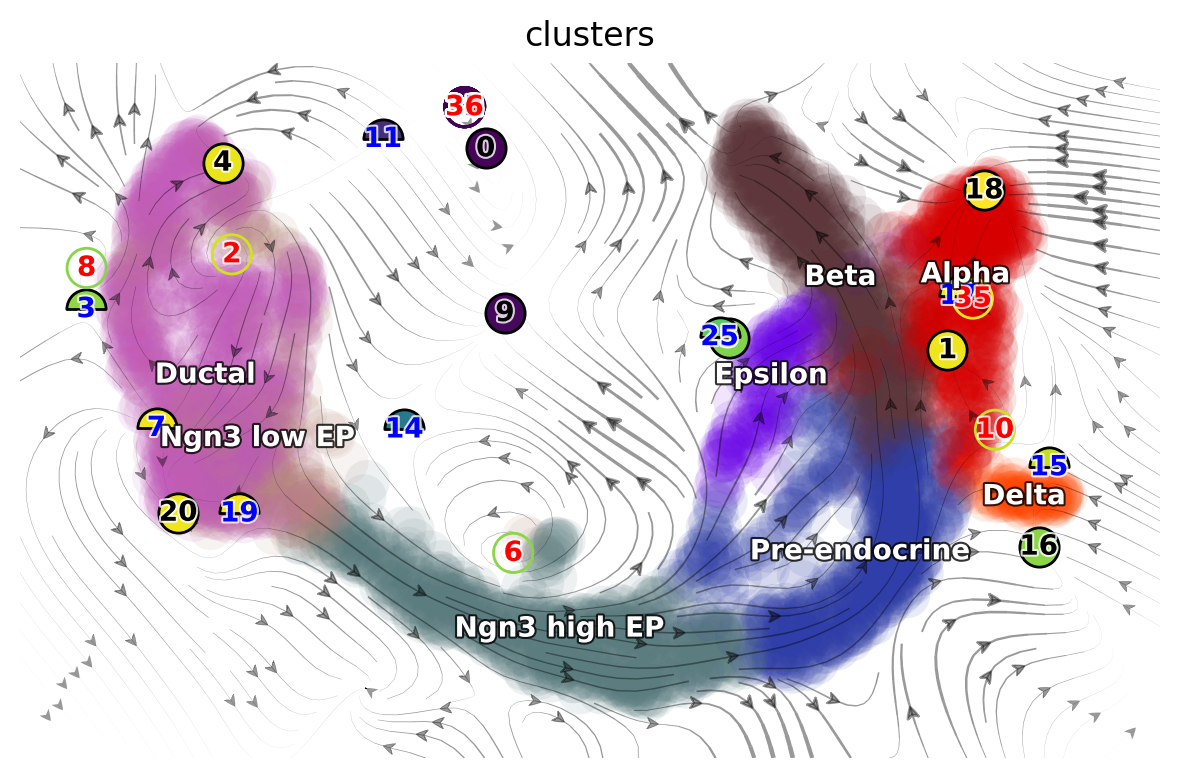

In [11]:
dyn.pl.topography(
    adata, basis="umap", background="white", color=["clusters"], streamline_color="black", show_legend="on data"
)


From the results above, we can observe that high acceleration is observed at the interface between early and late progenitors (magnitude change in velocity), and the bifurcation point where progenitors differentiate into stable cell types (direction change in velocity). Negative divergence is observed at the saddle point and attractors, and positive divergence at the bifurcation point and cell cycle of pancreatic buds. 

### Constructing a cell type state transition graph

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0013s]
|-----> [iterate groups] in progress: 12.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 146.29it/s]


|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 144.02it/s]


|-----> [iterate groups] in progress: 37.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 142.90it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 135.77it/s]


|-----> [iterate groups] in progress: 62.5000%

uniformly sampling points along a trajectory: 100%|██████████| 70/70 [00:00<00:00, 144.03it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 139.76it/s]


|-----> [iterate groups] in progress: 87.5000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 146.82it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 137.70it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [42.2887s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0012s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


<Figure size 600x400 with 0 Axes>

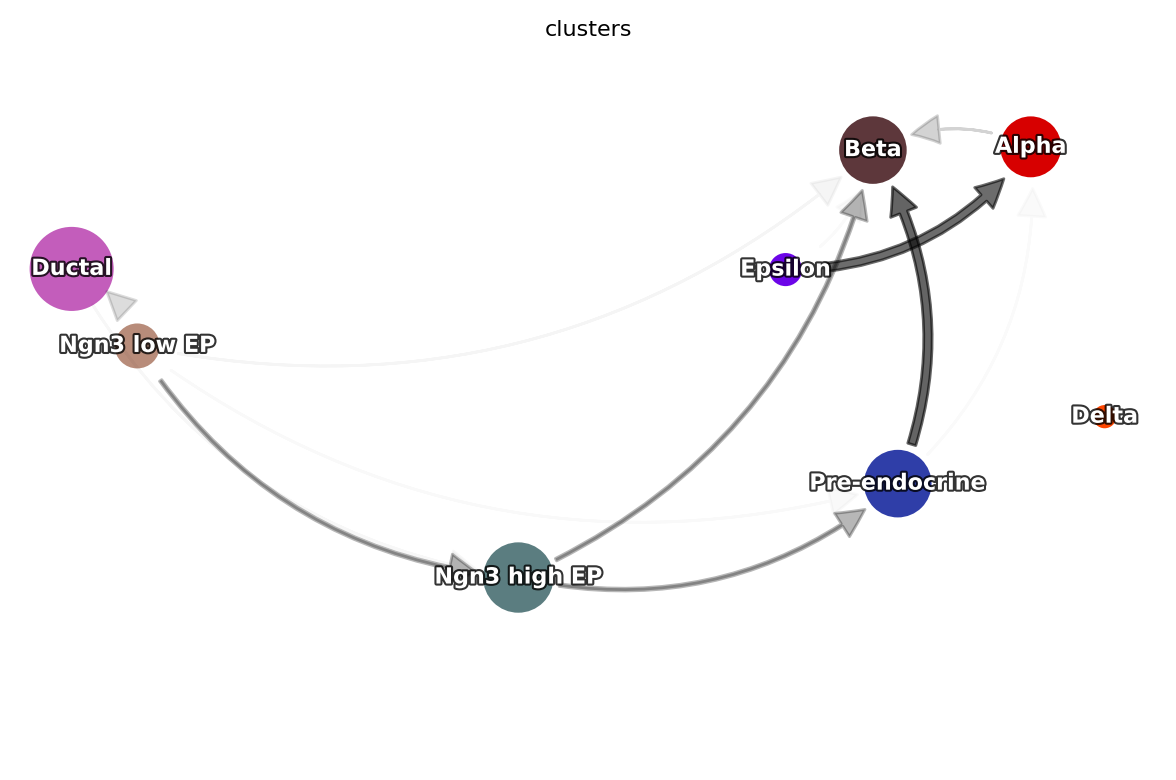

In [12]:
dyn.configuration.set_figure_params("dynamo", background="white")
dyn.pd.state_graph(adata, group='clusters', basis='pca', method='vf')
dyn.pl.state_graph(adata,
                   color=['clusters'],
                   group='clusters',
                   basis='umap',
                   show_legend='on data',
                   method='vf');

### Computing Jacobian and reveal regulator/effector gene relations via `dyn.vf.jacobian`

In [13]:
dyn.vf.jacobian(adata, regulators=pancreas_genes)

Transforming subset Jacobian: 100%|██████████| 3696/3696 [00:00<00:00, 59324.06it/s]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition

#### Pax4/Neurog3
Ngn3 activates Pax4 in progenitors, initiating pancreatic endocrinogenesis

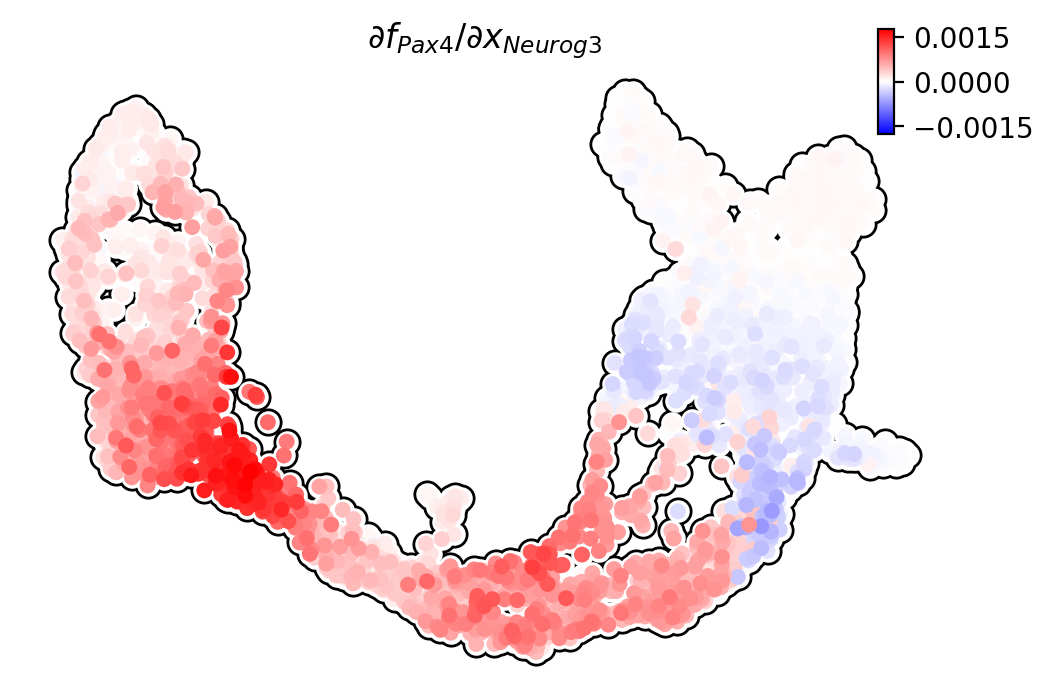

In [14]:
dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=[
        "Neurog3",
    ],
    effectors=["Pax4"],
    alpha=1,
)


#### Pax4/Arx

Jacobian analyses reveal mutual inhibition of Pax4 and Arx at the bifurcation point in progenitors. 

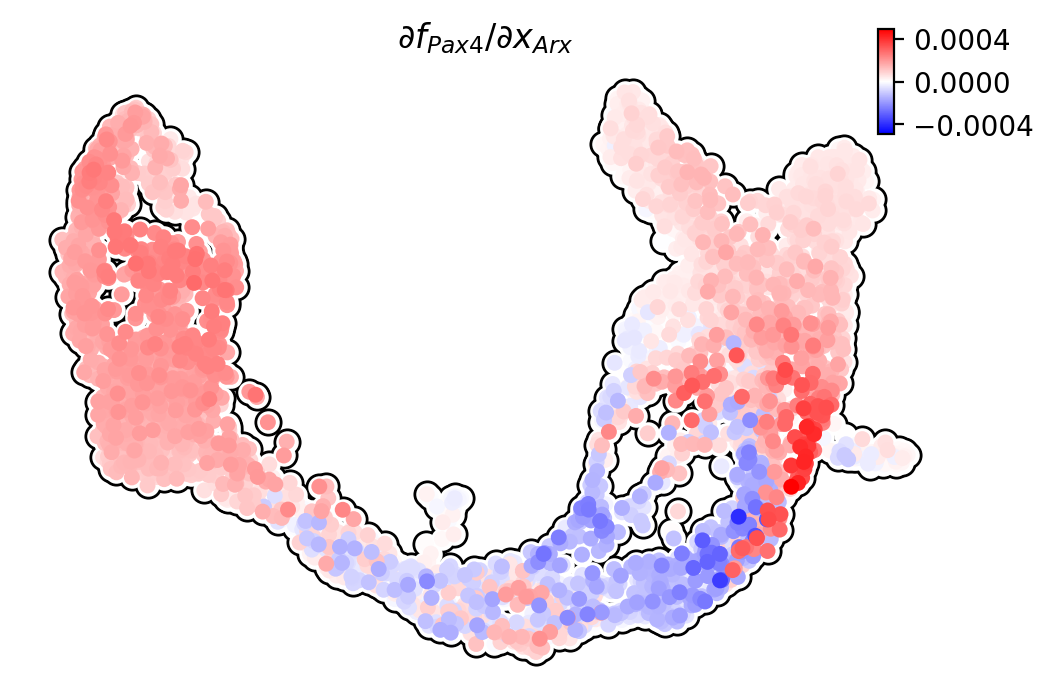

In [15]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Arx"], effectors=["Pax4"], alpha=1)


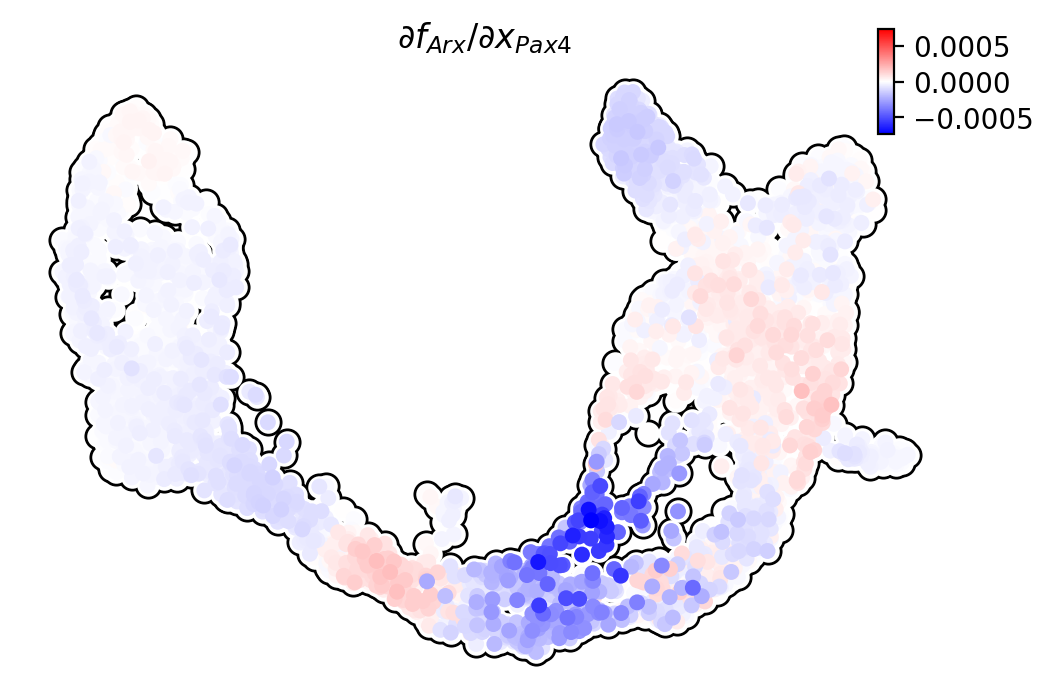

In [16]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Pax4"], effectors=["Arx"], alpha=1)


#### Pax4/Ins2
Pdx1 activates Ins2 in beta cells.

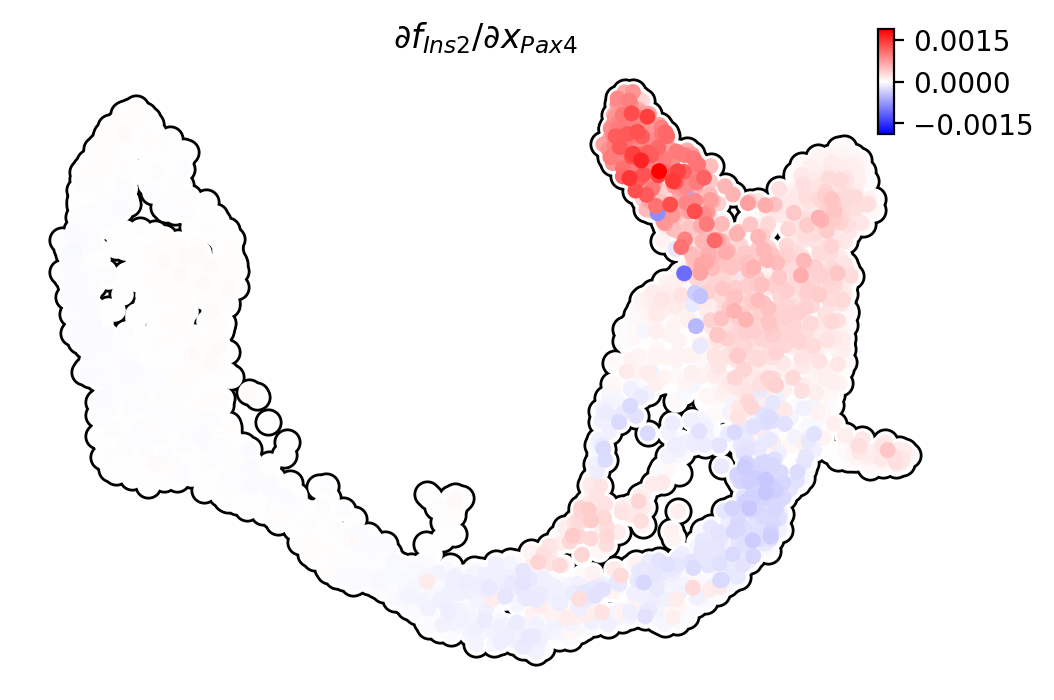

In [17]:
dyn.pl.jacobian(adata, basis="umap", regulators=["Pax4"], effectors=["Ins2"], alpha=1)


In [18]:
adata.obs["clusters"].unique()


['Pre-endocrine', 'Ductal', 'Alpha', 'Ngn3 high EP', 'Delta', 'Beta', 'Ngn3 low EP', 'Epsilon']
Categories (8, object): ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta', 'Alpha', 'Delta', 'Epsilon']

We can rank the elements in the Jacobian. There are 5 ways to rank the Jacobian:

(1) `'full_reg'`: top regulators are ranked for each effector for each cell group;

(2) `'full_eff'`: top effectors are ranked for each regulator for each cell group;

(3) '`reg`': top regulators in each cell group;

(4) '`eff`': top effectors in each cell group;

(5) '`int`': top effector-regulator pairs in each cell group.


The default mdoe is `'full_reg'`. Note that in `full_reg` and `full_eff` modes, a dictionary mapping clusters (cell type) to ranking dataframes is returned by `dyn.vf.rank_jacobian_genes`.

In [19]:
full_reg_rank = dyn.vf.rank_jacobian_genes(
    adata, groups="clusters", mode="full_reg", abs=True, output_values=True, return_df=True
)
full_eff_rank = dyn.vf.rank_jacobian_genes(
    adata, groups="clusters", mode="full_eff", abs=True, exclude_diagonal=True, output_values=True, return_df=True
)


In [20]:
full_reg_rank['Pre-endocrine'][:5]

Neurog3  Neurog3_values     Sox9  Sox9_values     Isl1  Isl1_values  \
0  Neurog3        0.000569      Gcg     0.000232      Gcg     0.000681   
1     Iapp        0.000453     Iapp     0.000186     Isl1     0.000663   
2      Gcg        0.000402  Neurog3     0.000115   Nkx6-1     0.000399   
3     Ghrl        0.000382     Ghrl     0.000096  Neurog3     0.000368   
4     Isl1        0.000366     Isl1     0.000089     Iapp     0.000330   

      Hes1  Hes1_values  Ins1  Ins1_values      Gcg  Gcg_values  Neurod1  \
0      Gcg     0.000089   Gcg     0.000504      Gcg    0.001130  Neurog3   
1     Iapp     0.000076  Iapp     0.000396     Ghrl    0.000568     Iapp   
2     Isl1     0.000063  Ins1     0.000365     Isl1    0.000251     Isl1   
3  Neurog3     0.000049  Ghrl     0.000324      Arx    0.000200     Ins1   
4     Ghrl     0.000044  Isl1     0.000320  Neurog3    0.000194     Pdx1   

   Neurod1_values   Nkx2-2  Nkx2-2_values   Ptf1a  Ptf1a_values     Pax6  \
0        0.000081     Ghrl       0.000043     Gcg      0.000019      Gcg   
1        0.000070     Iapp       0.000032    Ghrl      0.000016     Isl1   
2        0.000062     Isl1       0.000026    Iapp      0.000015  Neurog3   
3        0.000047      Gcg       0.000025    Pdx1      0.000013     Ins1   
4        0.000041  Neurog3       0.000023  Nkx6-1      0.000012     Iapp   

   Pax6_values   Nkx6-1  Nkx6-1_values  Pdx1  Pdx1_values     Pax4  \
0     0.000283     Isl1       0.000492  Isl1     0.000357  Neurog3   
1     0.000251     Ghrl       0.000390  Pdx1     0.000329     Isl1   
2     0.000224  Neurog3       0.000370   Arx     0.000306     Iapp   
3     0.000218      Arx       0.000251  Iapp     0.000266     Ghrl   
4     0.000197      Gcg       0.000245  Ghrl     0.000244     Pax4   

   Pax4_values    Ghrl  Ghrl_values     Iapp  Iapp_values  Ins2  Ins2_values  \
0     0.000335    Ghrl     0.002203     Iapp     0.001547   Gcg     0.000455   
1     0.000251    Isl1     0.000795     Isl1     0.001015  Isl1     0.000356   
2     0.000233    Pax4     0.000493      Gcg     0.000834  Ins1     0.000354   
3     0.000222    Iapp     0.000369     Pdx1     0.000772  Iapp     0.000301   
4     0.000179  Nkx6-1     0.000361  Neurog3     0.000430  Ins2     0.000271   

    Arx  Arx_values  
0  Isl1    0.000319  
1   Arx    0.000288  
2  Pdx1    0.000281  
3  Iapp    0.000200  
4  Ghrl    0.000188

### Arcplot shows gene regulatory networks in progenitors and beta cells
Next we use `dyn.vf.build_network_per_cluster` to build an `cluster2edges` dictionary which maps cluster name (celltype) to dataframes containing edge information that is necessary to build a `networkx` graph object. Then we can visualize regulatory networks via `dyn.pl.arcPlot`.

An example regulatory network in progenitor (Ductal) cells

|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [0.1333s]


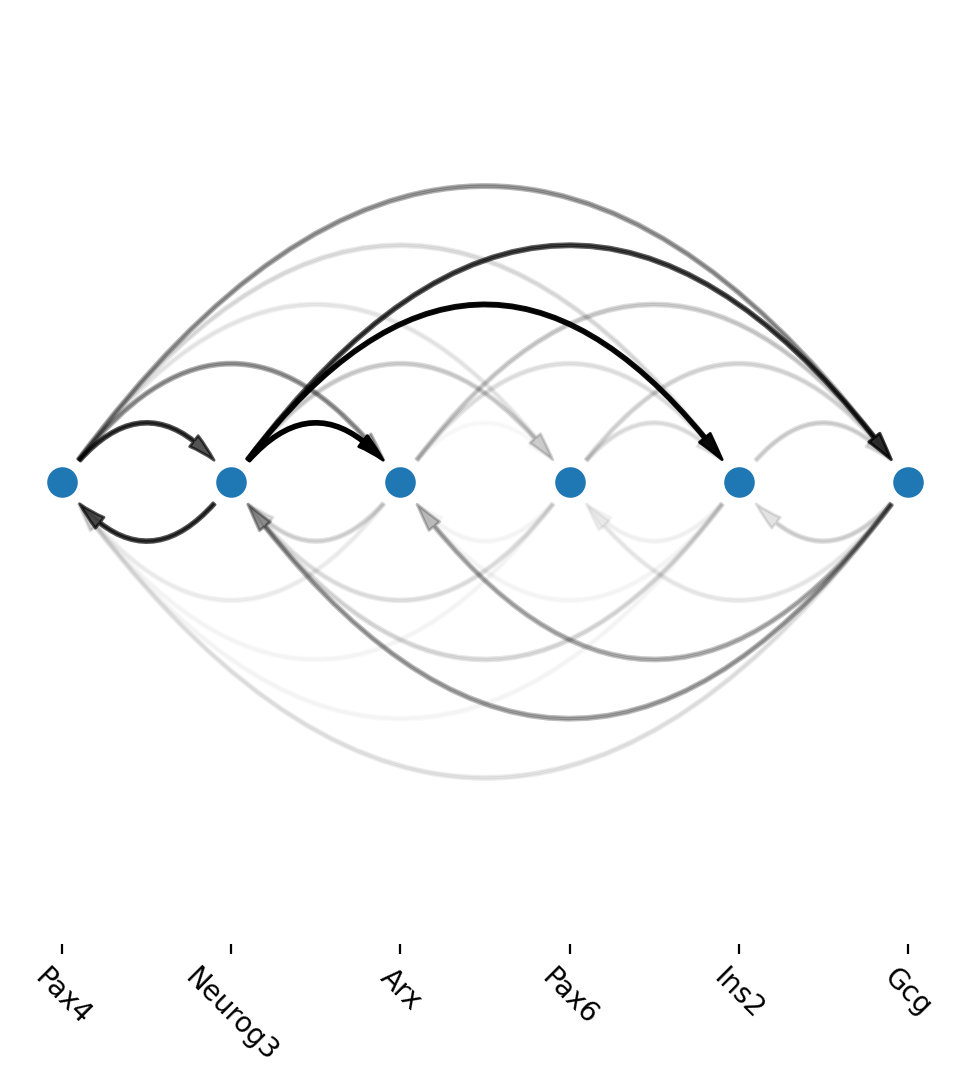

In [21]:
cell_type_regulators = ["Neurog3", "Arx", "Pax4", "Pax6", "Gcg", "Ins2", "Ss5", "Ghri"]
cluster2edges = dyn.vf.build_network_per_cluster(
    adata,
    cluster="clusters",
    cluster_names=None,
    full_reg_rank=full_reg_rank,
    full_eff_rank=full_eff_rank,
    genes=cell_type_regulators,
    n_top_genes=100,
)

import networkx as nx

network = nx.from_pandas_edgelist(
    cluster2edges["Ductal"], "regulator", "target", edge_attr="weight", create_using=nx.DiGraph()
)

ax = dyn.pl.arcPlot(
    adata, cluster="clusters", cluster_name="Beta", edges_list=None, network=network, color=None
)  # color="M_s")


Another example regulatory network in Beta cells

|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [0.1114s]


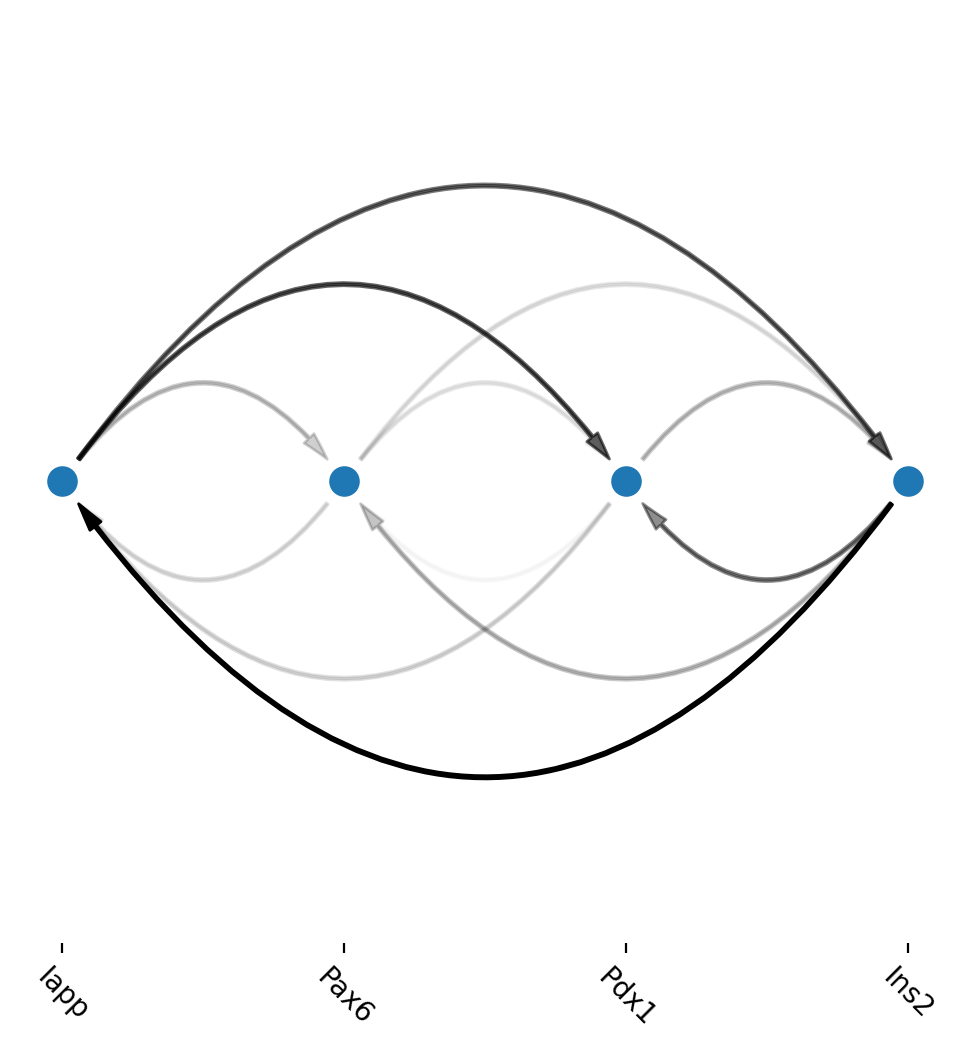

In [22]:
cell_type_regulators = ["Pax6", "Pdx1", "Iapp", "Ins2"]
cluster2edges = dyn.vf.build_network_per_cluster(
    adata,
    cluster="clusters",
    cluster_names=None,
    full_reg_rank=full_reg_rank,
    full_eff_rank=full_eff_rank,
    genes=cell_type_regulators,
    n_top_genes=100,
)

import networkx as nx

network = nx.from_pandas_edgelist(
    cluster2edges["Beta"], "regulator", "target", edge_attr="weight", create_using=nx.DiGraph()
)

ax = dyn.pl.arcPlot(
    adata, cluster="clusters", cluster_name="Beta", edges_list=None, network=network, color=None
)  # color="M_s")


### Acceleration Ranking

The acceleration can be computed based on the Jacobian. The acceleration indicates the rate of change in the velocity for a gene.

In [23]:
dyn.vf.acceleration(adata, basis='pca')
dyn.vf.rank_acceleration_genes(adata, groups='clusters')

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1464s]
|-----> <insert> acceleration to layers in AnnData Object.


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition

In [24]:
adata.uns['rank_acceleration'][:5]

Alpha  Beta   Delta     Ductal Epsilon Ngn3 high EP Ngn3 low EP  \
0       Ghrl  Ins1    Ins1      Cdc20  Tmsb4x         Chga     Neurog3   
1        Cck  Ins2     Cck      Ccnb2     Gcg         Chgb      Tmsb4x   
2        Mdk  Xist  Cdkn1a      Hmgb2  Nkx6-1       Tm4sf4      Btbd17   
3       Rbp4  Krt8    Ins2  Hist1h2bc   Rps19      Akr1c19         Mdk   
4  Serpina1c  Gpx3    Krt7      Birc5  Tmsb10       Cryba2        Btg2   

  Pre-endocrine  
0        Tmsb4x  
1           Pyy  
2          Iapp  
3          Calr  
4      Ppp1r14a

### Enrichment Analysis

Enrichment analysis allows us to see if top ranking genes are significantly enriched in certain biological pathways. For example, when we pick the top 100 accelerating genes in Ductal cells, we found that they are highly enriched in cell cycle related pathways.

In [25]:
enr = dyn.ext.enrichr(adata.uns['rank_acceleration']['Ductal'][:100].to_list(), organism='mouse', outdir='./enrichr')
enr.results.head(5)

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  regulation of mitotic cell cycle phase transit...  16/184  9.341163e-16   
1  mitotic sister chromatid segregation (GO:0000070)   11/82  2.897512e-13   
2          mitotic spindle organization (GO:0007052)    9/74  1.142841e-10   
3           metaphase plate congression (GO:0051310)    7/44  2.078922e-09   
4  establishment of chromosome localization (GO:0...    5/13  3.521204e-09   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.622389e-13            0                     0   22.371882   
1      1.182185e-10            0                     0   34.517962   
2      3.108527e-08            0                     0   30.180051   
3      4.241002e-07            0                     0   40.407149   
4      5.746605e-07            0                     0  130.868421   

   Combined Score                                              Genes  
0      774.222174  HSP90AA1;ANAPC16;NDE1;BUB1B;HMMR;DYNLL1;AURKA;...  
1      996.525054  CENPE;CCNB1;KIFC1;PRC1;NUSAP1;CDCA8;KIF23;KIF2...  
2      690.891800  CENPE;TPX2;CCNB1;KIFC1;PRC1;BIRC5;KIF23;AURKA;...  
3      807.796133          CENPE;CCNB1;CENPF;KIFC1;CDCA8;KIF2C;KIF22  
4     2547.283519                       CENPE;CENPF;NDE1;KIF2C;KIF22

<AxesSubplot:title={'center':'KEGG_2016'}, xlabel='-log$_{10}$(Adjusted P-value)'>

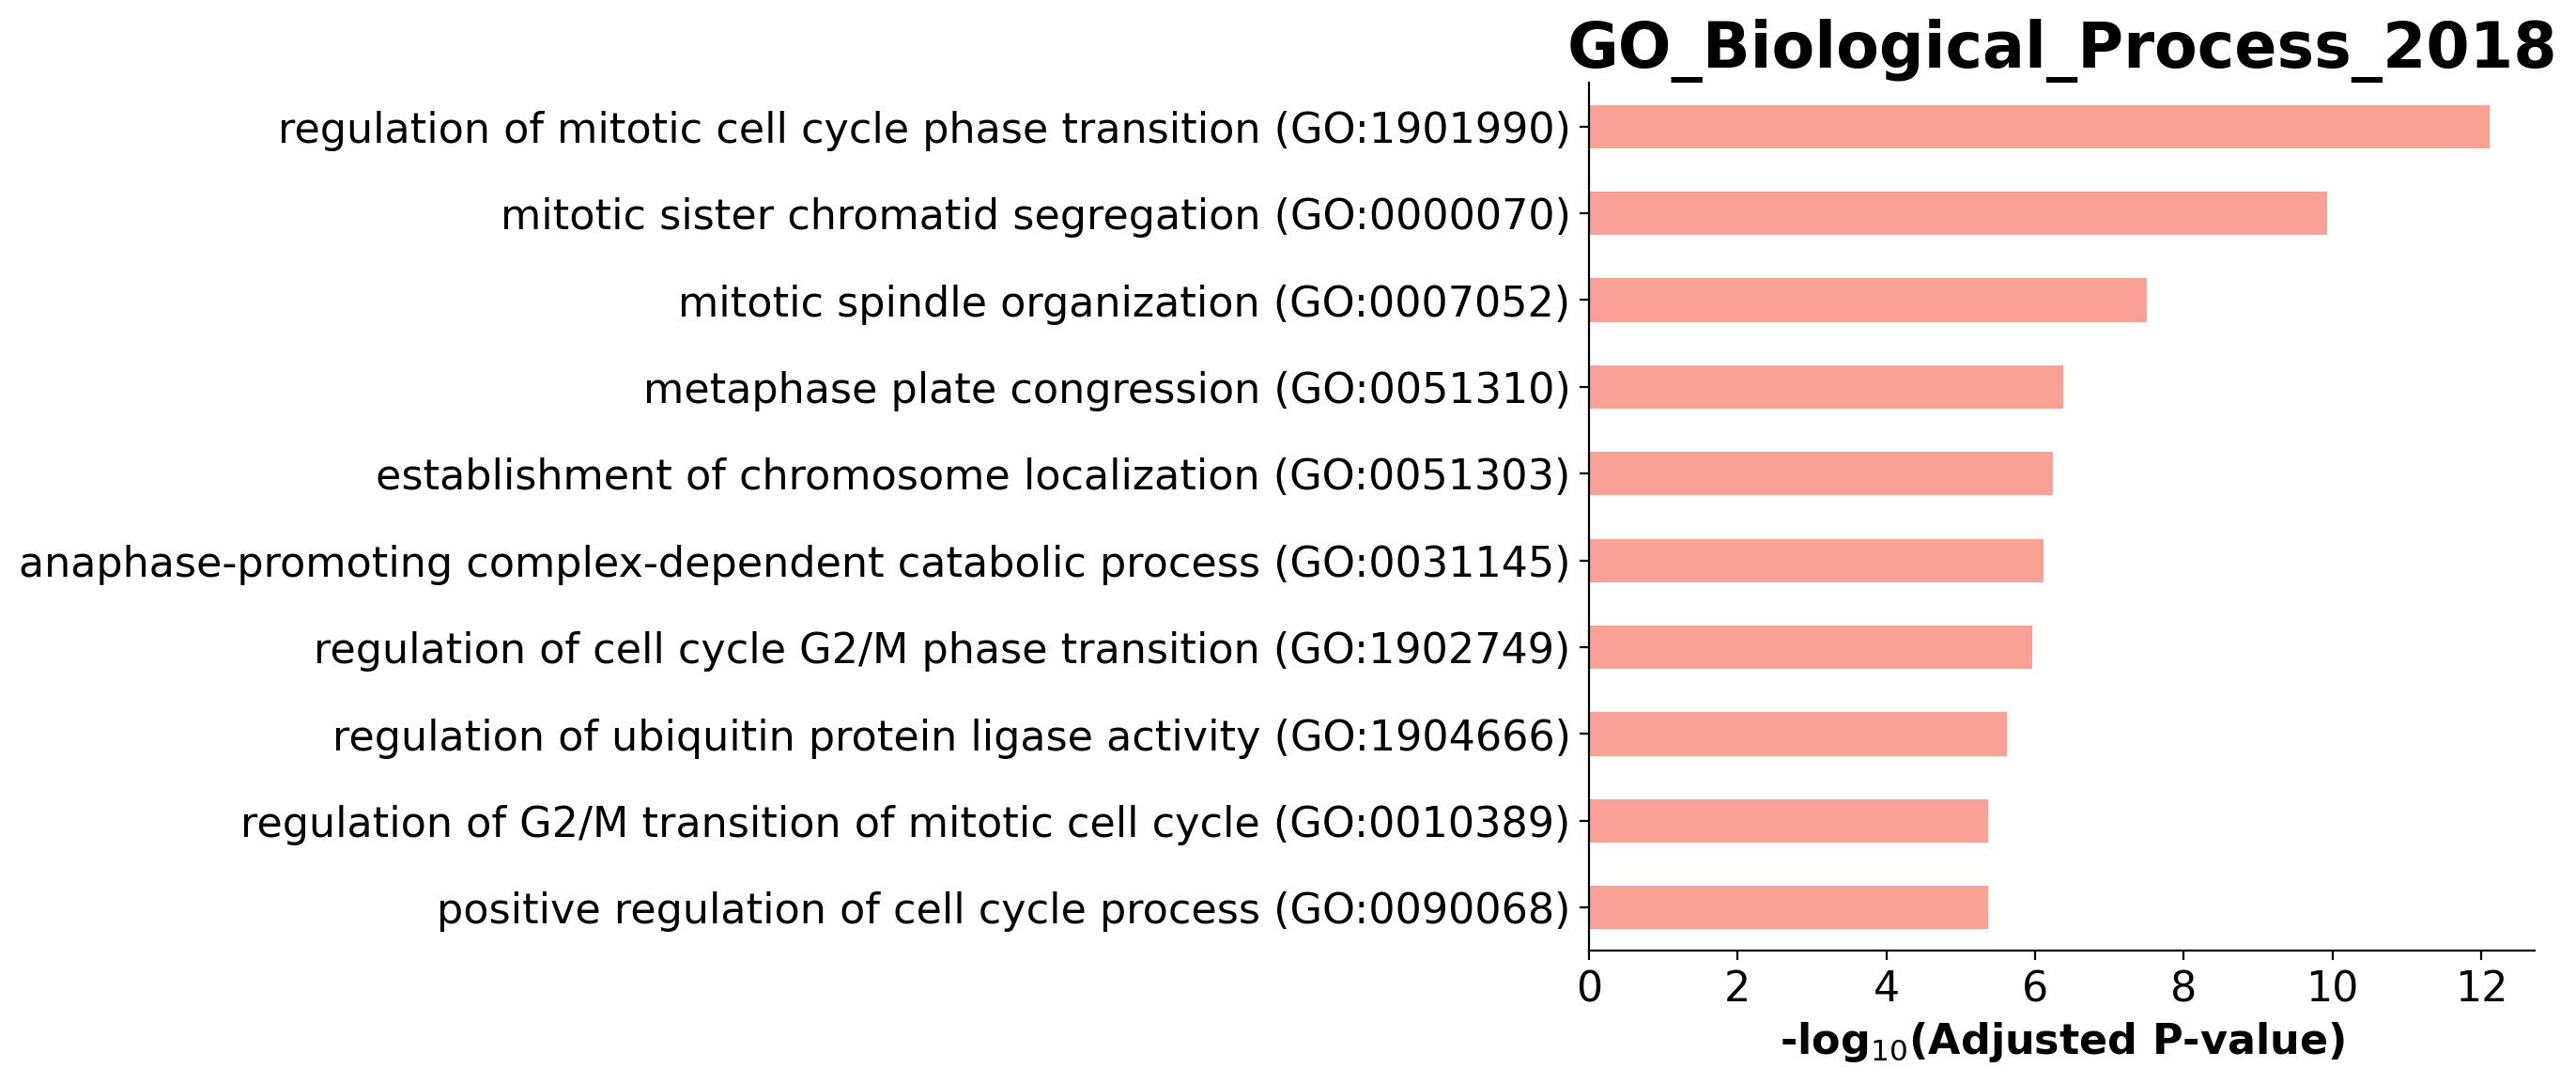

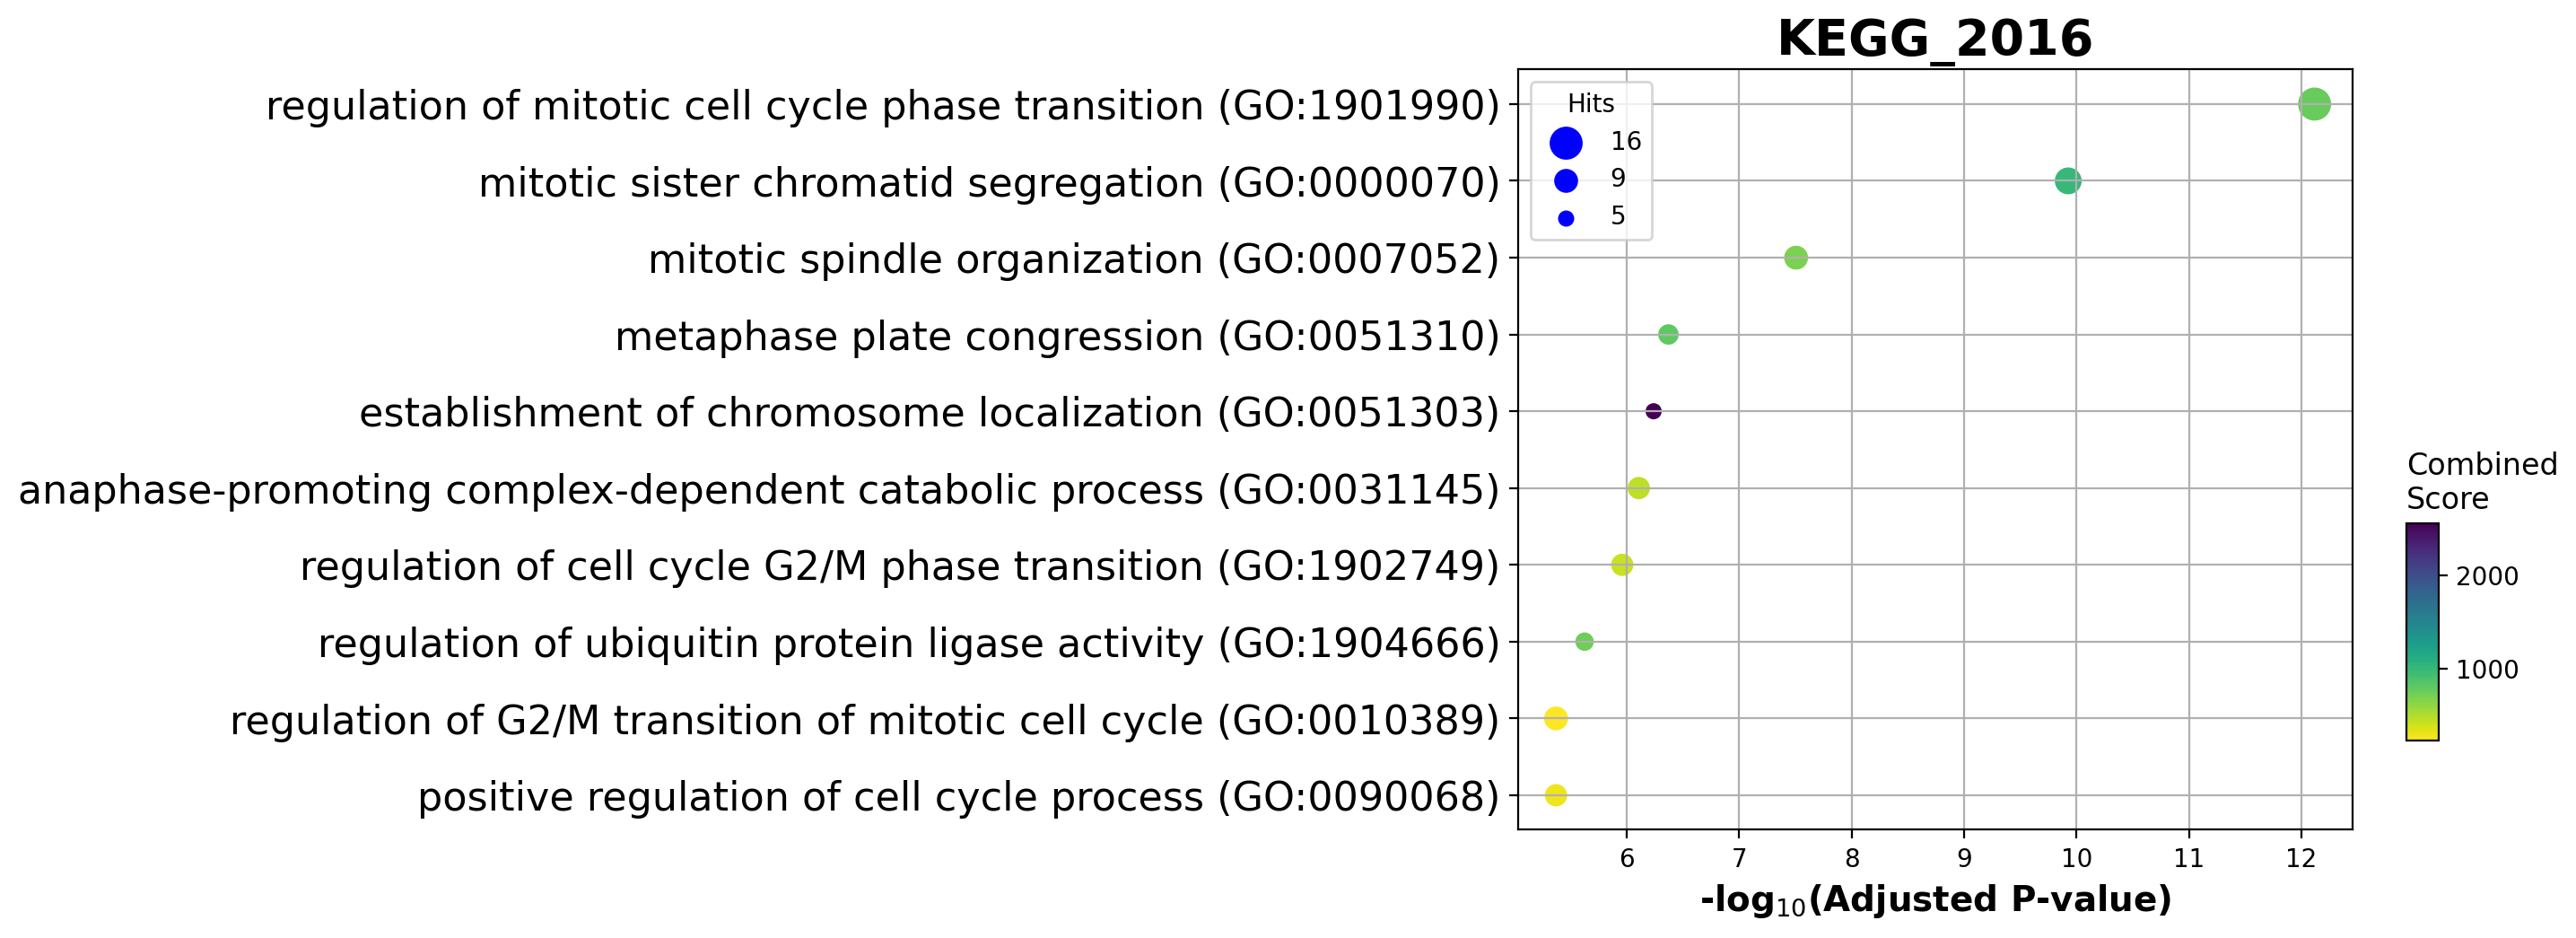

In [26]:
from gseapy.plot import barplot, dotplot
barplot(enr.res2d, title='GO_Biological_Process_2018', cutoff=0.05)
dotplot(enr.res2d, title='KEGG_2016',cmap='viridis_r', cutoff=0.05)

In [27]:
enr = dyn.ext.enrichr(adata.uns['rank_acceleration']['Ngn3 low EP'][:100].to_list(), organism='mouse', outdir='./enrichr')
enr.results.head(5)

2022-03-12 13:48:23,207 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap   P-value  \
0  purine ribonucleotide metabolic process (GO:00...    4/66  0.000334   
1             oxoacid metabolic process (GO:0043436)    3/32  0.000541   
2                      bone development (GO:0060348)    3/34  0.000648   
3  regulation of protein dephosphorylation (GO:00...    3/40  0.001048   
4  positive regulation of nuclear-transcribed mRN...    2/11  0.001322   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.159565            0                     0   13.331989   
1          0.159565            0                     0   21.191966   
2          0.159565            0                     0   19.822747   
3          0.159565            0                     0   16.603232   
4          0.159565            0                     0   45.104308   

   Combined Score                     Genes  
0      106.701278  TPST2;SULT2B1;ACLY;HSPA8  
1      159.391414       TPST2;SULT2B1;SULF2  
2      145.516274           GNAS;PPIB;SULF2  
3      113.917477   PPP1R14A;PPP1R14B;CALM2  
4      298.984305                 BTG2;TOB1